# Tutorial based on Python2 code:
https://docs.bigartm.org/en/latest/tutorials/python_tutorial.html

- Known issues - the code may have to be adjusted to work with latest version of python3
- artm.BatchVectorizer does not initialize dictionary if used with data_format='batches' - potentially solvable with https://docs.bigartm.org/en/latest/tutorials/python_userguide/loading_data.html

In [ ]:
# conda install python=3.9


In [ ]:
#!pip install bigartm

In [1]:
import artm

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='./data/', data_format='bow_uci',
                                        collection_name='kos', target_folder='kos_batches')

In [ ]:
lda = artm.LDA(num_topics=15, alpha=0.01, beta=0.001, cache_theta=True,
               num_document_passes=5, dictionary=batch_vectorizer.dictionary)

In [ ]:
lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [ ]:
print(lda.sparsity_phi_last_value)
print(lda.sparsity_theta_last_value)

In [ ]:
lda.perplexity_value

In [ ]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

In [ ]:
phi = lda.phi_
theta = lda.get_theta()

In [ ]:
# !pip install matplotlib

In [4]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

In [ ]:
batch_vectorizer = None
batch_vectorizer = artm.BatchVectorizer(data_path='./data', data_format='bow_uci',
                                            collection_name='kos', target_folder='kos')
#else:
    #Bugged - will not initialize dictionary
    #print(2)
    #batch_vectorizer = artm.BatchVectorizer(data_path='./kos',target_folder='kos', collection_name='kos', data_format='batches')

In [ ]:
dictionary = batch_vectorizer.dictionary
topic_names = ['topic_{}'.format(i) for i in range(15)]

model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15)])

In [ ]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [ ]:
model_artm.__dict__

In [ ]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_artm.initialize(dictionary = dictionary)
model_plsa.initialize(dictionary = dictionary)

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [ ]:
def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [ ]:
print_measures(model_plsa, model_artm)

In [ ]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [ ]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

In [ ]:
print_measures(model_plsa, model_artm)

In [ ]:
plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [ ]:
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ')
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

# Trying to load VW data

In [2]:
batch_vectorizer = artm.BatchVectorizer(data_path='./data/mytest_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')

Sparsity Phi: 0.000 (PLSA) vs. 0.887 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.666 (PLSA) vs. 0.861 (ARTM)
Kernel purity: 0.416 (PLSA) vs. 0.720 (ARTM)
Perplexity: 2433.657 (PLSA) vs. 2614.449 (ARTM)


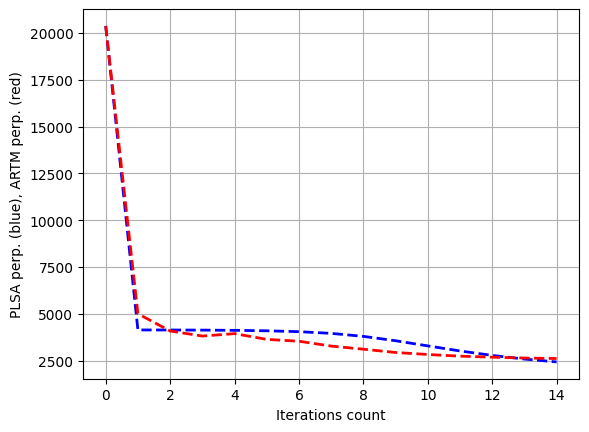

Sparsity Phi: 0.740 (PLSA) vs. 0.925 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.754 (PLSA) vs. 0.917 (ARTM)
Kernel purity: 0.646 (PLSA) vs. 0.904 (ARTM)
Perplexity: 1959.695 (PLSA) vs. 2530.433 (ARTM)


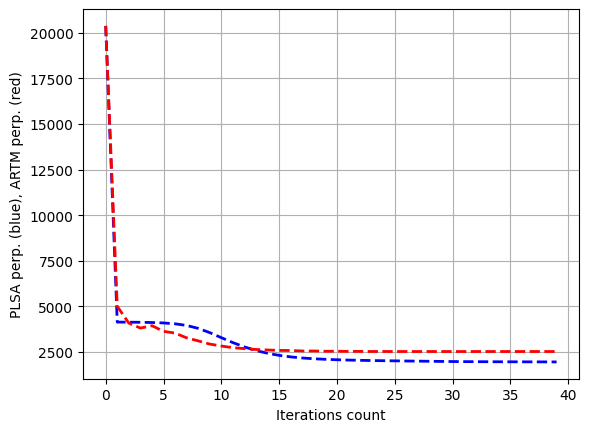

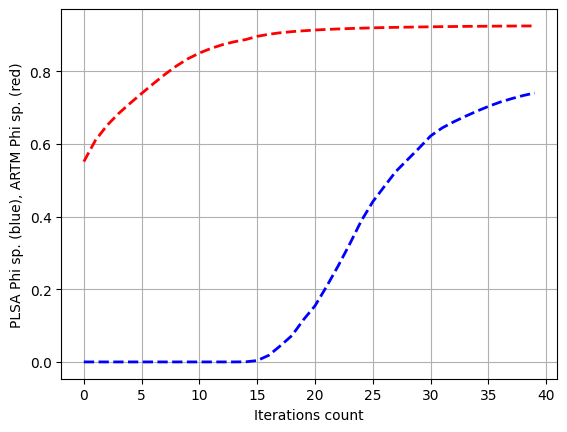

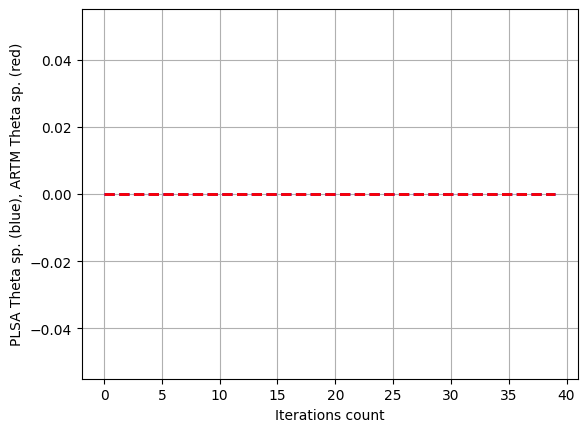

In [5]:
dictionary = batch_vectorizer.dictionary
topic_names = ['topic_{}'.format(i) for i in range(15)]

model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15)])

model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_artm.__dict__

model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_artm.initialize(dictionary = dictionary)
model_plsa.initialize(dictionary = dictionary)

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()

print_measures(model_plsa, model_artm)

model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

print_measures(model_plsa, model_artm)

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()